# Road Traffic Vehicle Counting Exam

In this exam, you will use the YOLO (You Only Look Once) object detection model to analyze a video of road traffic. Your primary task is to count the number of vehicles exiting the road at each of the four exits (located at the top, bottom, left, and right of the frame). The video for this task is provided at `Datasets/YOLO_Exam_Video.mp4`.

## Objectives
- Load and process the video using OpenCV.
- Utilize the YOLO model to detect vehicles in each frame.
- Manipulate the video frames using OpenCV.
- Track vehicles as they move across the video frames.
- Count the number of vehicles exiting via the top street.
- Count the number of vehicles exiting via the bottom street.
- Count the number of vehicles exiting via the left street.
- Count the number of vehicles exiting via the right street.


## Setup Environment

Before you begin, ensure you have the necessary libraries installed. You will need `opencv`, and `ultralytics` among others.
If these are not installed, you should install them.

In [20]:
# Install ultralytics to call YOLO model.
!pip install ultralytics

In [21]:
import cv2
from ultralytics import YOLO
import gdown
import numpy as np

In [22]:
# Since the files can't be publicly accessed we have to mount the drive and call it from there:
# Mount the drive to get the model and video:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load the YOLO Model

You will first need to load the YOLO model, there is a custom model for this exam called `YOLO_Model.pt` under Datasets file ⚠️ PLEASE USE THIS MODEL AND DO NOT USE ANY OTHER MODEL ⚠️.
Write the code to load the YOLO model below:

In [23]:
model = YOLO('/content/drive/MyDrive/SDAIA T5 DataSets/Night_Task_Week6/Dataset/YOLO_Model.pt')

In [24]:
# Get the model info:
model.info()

Model summary: 365 layers, 68,156,460 parameters, 0 gradients, 258.1 GFLOPs


(365, 68156460, 0, 258.13867519999997)

## Prepare the Video Capture

Create a variable to capture the video frames, you can use `cv2.VideoCapture()` to achive this.

In [25]:
# create a video vapture instance to read the stream and set the fps and...
vid_path = '/content/drive/MyDrive/SDAIA T5 DataSets/Night_Task_Week6/Dataset/YOLO_Video.mp4'
cap = cv2.VideoCapture(vid_path)

## Get Video Information

You can use `cv2` library to get these information fro the `VideoCapture()` variable you created to extract these information:
* `height`: Video's height.
* `width`: Video's width.
* `fps`: Video's frames.

In [26]:
# Let's get the video properties from our 'cap':
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) # This method retrieves the width of the frames in the video, NOTE: we cast into int as the method returns a floating point.
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # This method retrieves the height of the frames in the video
fps = int(cap.get(cv2.CAP_PROP_FPS)) # Get the frames per second.

## Prepare Video Writer to Store the Output

Create a variable that uses `cv2.VideoCapture()` to save the video with the bounding boxes, specified Region of Interest rectangle (ROI) and the counted vehicles on each sides. You will need to make the video with the same `fps`, `width`, `height`, and specify the codec and output path of the video.

In [27]:
# This snippet sets up the creation of a new video file that will store the processed video frames.
output_path = '/content/ROI_Counter_Video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height)) # allows you to write on video files frame by frame

## Expermint to get the `(x1, y1, x2, y2)` of the ROI

### Hint
When defining the Regions of Interest (ROIs) for detecting vehicles exiting the road, consider the coordinates that outline the relevant areas. These coordinates can be specified as `(x1, y1, x2, y2)`, where `(x1, y1)` is the top-left corner and `(x2, y2)` is the bottom-right corner of the rectangle.

Experiment with different coordinates to accurately cover the streets where vehicles exit. Visualize these ROIs by drawing rectangles on a frame of the video and adjust the coordinates as needed until you capture the desired areas effectively.

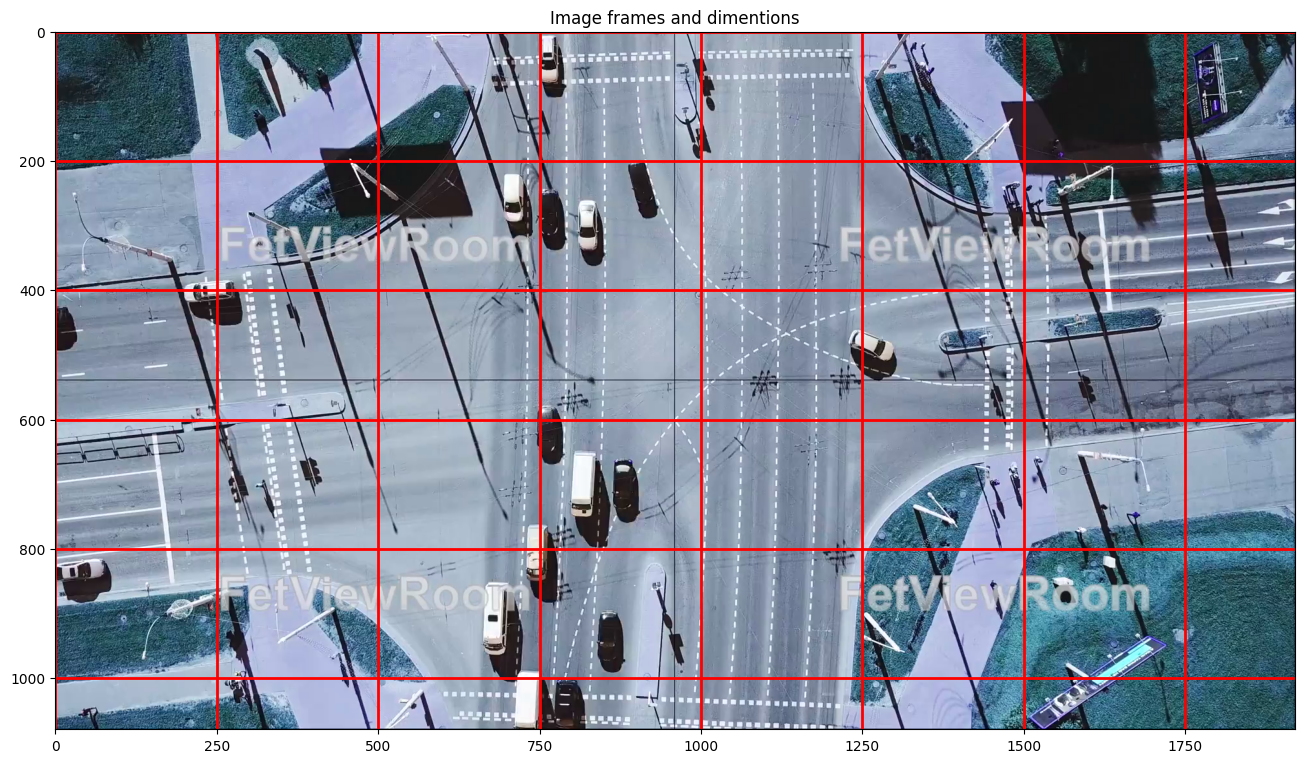

In [28]:
# Lets take a look at our video by plotting some frames, of which we'll decide my (Xn,Yn):
import matplotlib.pyplot as plt
bol, frame = cap.read()
plt.figure(figsize = (16,12))
plt.title('Image frames and dimentions')
plt.grid(bol, color='r', linestyle='-', linewidth=2)
plt.imshow(frame);

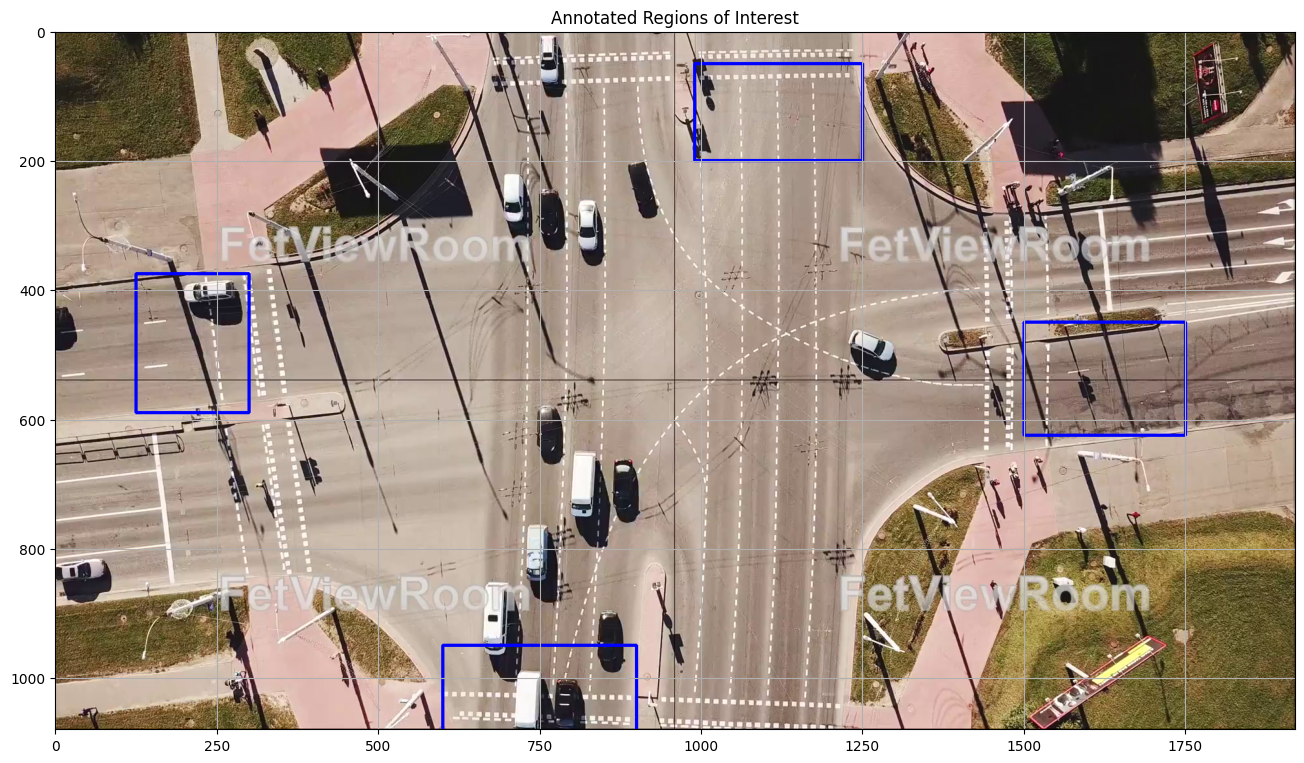

In [29]:
# Define the coordinates for the regions of interest (ROIs)
regions = [
    ((990, 50), (1250, 200)),    # Top region, the tuples reflect the top left and bottom right points
    ((600, 950), (900, 1100)),   # Bottom region
    ((125, 375), (300, 590)),    # Left region
    ((1500, 450), (1750, 625))   # Right region
]

# Iterate through each region and draw the rectangle on the frame
for (xy1, xy2) in regions:
    cv2.rectangle(frame, xy1, xy2, (255, 0, 0), 3)  # Draw rectangle with blue color

# Display the frame with the rectangles
plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
plt.title('Annotated Regions of Interest')
plt.grid(True)
plt.show()

## Process Video Frames and Identify Vehicles Left the Road Form Each Street

For each frame in the video, use the YOLO model to detect and track vehicles. You will need to write a loop that processes each frame and applies the YOLO model.

In each frame, after detecting the vehicles, determine whether they exited the road via the top, bottom, left, or right street. You can use the positions of the bounding boxes provided by YOLO to do this.

- The video should display bounding boxes around the detected objects.
- The video should display your name on the top.
- It should display the calculated center of each vehicle.
- The video should display the confidence score, alongside the object ID and class ID of each detected and tracked object.
- The video should display the rectangles representing the regions where you count the vehicles that have crossed and exited.
- The video should display the number of vehicles that exited via the top street.
- The video should display the number of vehicles that exited via the bottom street.
- The video should display the number of vehicles that exited via the left street.
- The video should display the number of vehicles that exited via the right street.

In [30]:
# Before going into counting and iterating over the frames we need to define sets to to store already counted vehicals.
# Define sets and counters:
top = set()
bottom = set()
left = set()
right = set()
# Counters to count cars crossing the ROI.
top_c = 0
bottom_c = 0
left_c = 0
right_c= 0

In [32]:
while cap.isOpened():
  bol, frame = cap.read()
  if not bol:
    print('process finished |or| no frame')
    break

  results= model.track(frame, persist=True, show= False)
  for result in results:
    boxes = result.boxes.xyxy.cpu().numpy()
    c_ids = result.boxes.cls.cpu().numpy()
    conf = result.boxes.conf.cpu().numpy()
    ids = result.boxes.id.cpu().numpy()

    for box, conf, class_id, id in zip(boxes, conf, c_ids, ids):
      x1, y1, x2, y2 = map(int, box)
      center = (x1 + x2) // 2,(y1 + y2) //2

      label = f'{model.names[int(class_id)]}:{int(id)} :{conf:.2f}'

      cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
      cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

      if center[1] <= 200 and center[1] >= 50 and id not in top and center[0] <= 1250 and center[0] >= 990 and id not in top:
        top_c += 1
        top.add(id)

      if center[1] <= 1100 and center[1] >= 950 and id not in bottom and center[0] <= 900 and center[0] >= 600 and id not in bottom:
        bottom_c += 1
        bottom.add(id)

      if center[1] <= 590 and center[1] >= 375 and id not in left and center[0] <= 300 and center[0] >= 125 and id not in left:
        left_c += 1
        left.add(id)

      if center[1] <= 625 and center[1] >= 450 and id not in right and center[0] <= 1750 and center[0] >= 1500 and id not in right:
        right_c += 1
        right.add(id)


  cv2.rectangle(frame, (10, 30), (350, 75), (0, 0, 0))
  cv2.putText(frame, 'Khalid AlBakr', (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
  cv2.putText(frame, f'{top_c}', (990 + 25, 50 + 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
  cv2.putText(frame, f'{bottom_c}', (600 + 25, 950 + 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
  cv2.putText(frame, f'{left_c}', (125 + 10, 375 + 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
  cv2.putText(frame, f'{right_c}', (1750 - 25, 450 - 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

  top_reg = cv2.rectangle(frame ,(990,50),(1250,200),(255,0,0),3)
  bottom_reg = cv2.rectangle(frame ,(600,950),(900,1100),(255,0,0),3)
  left_reg = cv2.rectangle(frame ,(125,375),(300,590),(255,0,0),3)
  right_reg = cv2.rectangle(frame ,(1750,450),(1500,625),(255,0,0),3)

  out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()



0: 384x640 15 cars, 12.8ms
Speed: 2.8ms preprocess, 12.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 cars, 13.6ms
Speed: 2.2ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 cars, 13.2ms
Speed: 2.4ms preprocess, 13.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bus, 14 cars, 13.7ms
Speed: 2.8ms preprocess, 13.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 cars, 18.9ms
Speed: 3.4ms preprocess, 18.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 cars, 13.3ms
Speed: 2.5ms preprocess, 13.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 cars, 13.7ms
Speed: 2.8ms preprocess, 13.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 cars, 12.7ms
Speed: 2.7ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384

## Save and Submit Your Work

Submit both the notebook and the output video